In [1]:
import sys
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/models/')
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/')
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import least_squares
import p3_cost_funcs
import comp_models
import utils
import seaborn as sns


dat = pd.read_csv('../Data/bx_data.csv', index_col=0)
dat = dat[['trustee','turker_id', 'trial', 'inv','mult', 'im', 'exp','pred', 'ret', 'p2_strat']]

niter = 100
results = pd.DataFrame(columns=['trueAlpha', 'trueTau', 'recovAlpha', 'recovTau', 'cost', 'r'])
dat.head()

,trustee,turker_id,trial,inv,mult,im,exp,pred,ret,p2_strat
0,93,1,0,5,2,10,10,5,7,GA
1,93,1,1,9,2,18,18,7,14,GA
2,93,1,2,8,4,32,16,20,16,GA
3,93,1,3,5,4,20,10,9,10,GA
4,93,1,4,3,2,6,6,3,4,GA


In [5]:
for turk in dat.turker_id.unique()[:20]:
    print('simulating/recovering turker:', turk)
    # simulate with arbitrary params
    game = dat.loc[dat.turker_id == turk]
    game.drop(labels='pred', axis=1, inplace=True )
    truAlpha = np.random.uniform()
    truTau = np.random.uniform(low=.001)
    truGame = game.copy()
    truGame['pred'] = comp_models.imm_learn(game=truGame,folk_thry=utils.folk_params, alpha=truAlpha,tau=truTau)
    #Fit the simulation
    fitIters = np.zeros([niter, 5])
    for i in range(niter):
        param0 = [np.random.uniform(), np.random.uniform(low=.001)]
        fitIters[i,0:2] = [param0[0], param0[1]]
        result_lsq = least_squares(fun=p3_cost_funcs.imm_costfun, x0=param0, args=(truGame,utils.folk_params ),
                                   bounds=([0,.001], [1,1]), diff_step=.05)

        [param1, param2] = result_lsq.x
        cost = result_lsq.cost
        fitIters[i, 2:5] = [param1, param2, cost]
    cost_selected = np.min(fitIters[:, 4])
    recovAlpha = fitIters[fitIters[:,4]== cost_selected, 2][0]
    recovTau = fitIters[fitIters[:,4]== cost_selected, 3][0]
    sse = cost_selected* 2
    #simulate with fitted params
    recovGame = game.copy()
    recovGame['pred'] = comp_models.imm_learn(game=recovGame,folk_thry=utils.folk_params, alpha=recovAlpha,tau= recovTau).astype(int).tolist()
    # correlate initial and recovered model predictions
    r = scipy.stats.pearsonr( truGame['pred'], recovGame['pred'] )[0]
    results = results.append(pd.DataFrame([[truAlpha, truTau, recovAlpha, recovTau, sse, r]],
                                          columns=results.columns)).reset_index(drop=True)
    if turk%5 == 0:
        results.to_csv('../Results/param_recov_'+str(niter)+'iters.csv', sep=',')

simulating/recovering turker: 1
simulating/recovering turker: 3
simulating/recovering turker: 4
simulating/recovering turker: 5
simulating/recovering turker: 7
simulating/recovering turker: 9
simulating/recovering turker: 10
simulating/recovering turker: 11
simulating/recovering turker: 13
simulating/recovering turker: 14
simulating/recovering turker: 15
simulating/recovering turker: 16
simulating/recovering turker: 17
simulating/recovering turker: 18
simulating/recovering turker: 19
simulating/recovering turker: 20
simulating/recovering turker: 21
simulating/recovering turker: 22
simulating/recovering turker: 23
simulating/recovering turker: 24


/Users/bryangonzalez/opt/anaconda3/envs/mTurk/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
results.to_csv('results/param_recov_'+str(niter)+'iters.csv', sep=',')


In [3]:
results = pd.read_csv('../Results/param_recov_300iters.csv', index_col=0).reset_index(drop=True)

#results['r_val'] = [float(results['r'][x].strip(')(').split(',')[0]) for x in np.arange(len(results))]
#results['corr_pVal'] = [float(results['r'][x].strip(')(').split(',')[1]) for x in np.arange(len(results))]

In [5]:
trialCorr = np.mean(results['r'])
alphaCorr = scipy.stats.pearsonr(results['trueAlpha'],results['recovAlpha'])
tauCorr = scipy.stats.pearsonr(results['trueTau'],results['recovTau'])
print(trialCorr)
print(alphaCorr)
print(tauCorr)
scipy.stats.ttest_1samp(results['r'],0,nan_policy='omit')

0.5905773411746118
(0.11891776088623013, 0.017342693196780147)
(0.46178883626195555, 1.6032296751138554e-22)


Ttest_1sampResult(statistic=67.83674339114178, pvalue=3.584653102448623e-221)

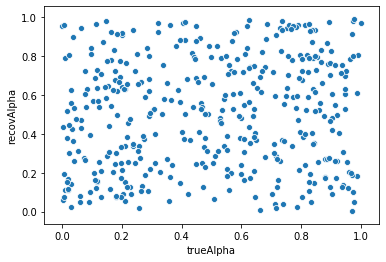

In [8]:
import seaborn as sns
sns.scatterplot(x='trueAlpha', y='recovAlpha', data=results)

In [28]:
scipy.stats.pearsonr(results['trueAlpha'],results['recovAlpha'])

KeyError: 'truAlpha'

# rescorla-wagner model parameter recovery

In [ ]:
niter = 300
results = pd.DataFrame(columns=['trueAlpha', 'trueTau', 'recovAlpha', 'recovTau', 'cost', 'r'])
dat.head()

In [ ]:
rw_results = pd.DataFrame(columns=['trueAlpha', 'recovAlpha', 'cost', 'r'])


for turk in dat.turker_id.unique()[:30]:
    print('simulating/recovering turker:', turk)
    # simulate with arbitrary params
    game = dat.loc[dat.turker_id == turk]
    game.drop(labels='pred', axis=1, inplace=True )
    truAlpha = np.random.uniform()
    #truTau = np.random.uniform(low=.001)
    truGame = game.copy()
    truGame['pred'] = comp_models.rw_learn(game=truGame, alpha=truAlpha)
    #Fit the simulation
    fitIters = np.zeros([niter, 5])
    for i in range(niter):
        param0 = [np.random.uniform(), np.nan]
        fitIters[i,0:2] = [param0[0], param0[1]]
        result_lsq = least_squares(fun=p3_cost_funcs.rw_costfun, x0=param0[0], args=(truGame,),
                                   bounds=([0], [1]), diff_step=.05)

        param1 = result_lsq.x
        cost = result_lsq.cost
        fitIters[i, 2:5] = [param1, np.nan, cost]
    cost_selected = np.min(fitIters[:, 4])
    recovAlpha = fitIters[fitIters[:,4]== cost_selected, 2][0]
    #recovTau = fitIters[fitIters[:,4]== cost_selected, 3][0]
    sse = cost_selected* 2
    #simulate with fitted params
    recovGame = game.copy()
    recovGame['pred'] = comp_models.rw_learn(game=recovGame, alpha=recovAlpha).astype(int).tolist()
    # correlate initial and recovered model predictions
    r = scipy.stats.pearsonr( truGame['pred'], recovGame['pred'] )[0]
    rw_results = rw_results.append(pd.DataFrame([[truAlpha, recovAlpha, sse, r]], columns=results.columns)).reset_index(drop=True)
    if turk%5 == 0:
        rw_results.to_csv('results/rw_param_recov_'+str(niter)+'iters.csv', sep=',')

In [5]:
xx = np.mean(results['r'])

In [7]:
rw_results.to_csv('results/rw_param_recov_'+str(niter)+'iters.csv', sep=',')

NameError: name 'rw_results' is not defined

In [ ]:
xx =